# Import Required Libraries
Import necessary libraries for data processing, regex pattern matching, transformer models, and visualization.

In [2]:
# Import Required Libraries

# Data processing libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import torch
import json

# Regex pattern matching
import re

# Transformer models
from transformers import pipeline
from datasets import Dataset

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for plots
sns.set(style="whitegrid")

# Set defalt plt font size and typeface to times
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'font.family': 'Times New Roman'})

# Load and Prepare Data
Load the JSON file containing abstracts, extract the abstracts, and perform basic cleaning operations.

In [3]:
# Load the JSON file containing abstracts using pandas
import pandas as pd

# Load data with pandas
df = pd.read_json("../data/05_filtered_genai_applications.json")

# Print count for verification
print(f"Total articles processed: {len(df)}")

Total articles processed: 307


# Define Smart City Domains
Create a comprehensive dictionary of smart city domains (e.g., governance, mobility, safety, infrastructure, environment, healthcare) with detailed descriptions for each.

In [4]:
# Load the JSON file with smart city domains
with open('../data/config/smart_city_domains_extended.json', 'r') as f:
    smart_city_domains = json.load(f)

# Flatten the hierarchy into subdomain labels with their context
flattened_domains = {}
for main_domain, subdomains in smart_city_domains.items():
    for subdomain in subdomains:
        # Create a key-value pair where the subdomain is the key
        # and includes context about its parent domain
        flattened_domains[subdomain] = f"{subdomain} (part of {main_domain})"

# Create labels list from subdomains
labels = list(flattened_domains.keys())

# Print the number of domains and some example labels
print(f"Total number of domains: {len(labels)}")
print(f"Example domains: {labels[:5]}")

Total number of domains: 48
Example domains: ['Economy', 'Business', 'Economic Management', 'Socioeconomics', 'Marketing']


# Build Transformer Model
Initialize a pre-trained transformer model (e.g., BERT, RoBERTa) and set up either a zero-shot classification approach or fine-tune the model if labeled data is available.

In [5]:
# Build Transformer Model for Zero-Shot Classification
# model = "facebook/bart-large-mnli"
model = "MoritzLaurer/deberta-v3-large-zeroshot-v2.0-c"

# Set tokenizers parallelism
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Check available devices
print("CUDA available:", torch.cuda.is_available())
print("MPS available:", torch.backends.mps.is_available())

# Set device for Apple Silicon
if torch.backends.mps.is_available():
    device = "mps"
    print("Using MPS (Metal Performance Shaders)")
elif torch.cuda.is_available():
    device = 0
    print("Using CUDA GPU")
else:
    device = -1
    print("Using CPU")


device = torch.device(device)

# Initialize the classifier with device setting
try:
    classifier = pipeline(
        "zero-shot-classification", model=model, device=device, multi_label=True
    )
    print("Classifier initialized successfully")
except Exception as e:
    print(f"Error initializing with {device}, falling back to CPU")
    device = -1
    classifier = pipeline(
        "zero-shot-classification", model=model, device=device, multi_label=True
    )

# Function to classify sentences into smart city domains
def classify_sentences(sentences, labels):
    results = []
    for sentence in tqdm(sentences):
        if sentence:  # Check if sentence is not empty
            try:
                result = classifier(
                    sentence,
                    candidate_labels=labels,
                    hypothesis_template="This text is about {}.",
                )
                results.append(result)
            except Exception as e:
                print(f"Error processing sentence: {str(e)}")
                results.append(None)
    return results

CUDA available: True
MPS available: False
Using CUDA GPU


Device set to use cuda:0


Classifier initialized successfully


In [6]:
# Test with a single sentence first
test_sentence = "Fire detection has held stringent importance in computer vision for over half a century. The development of early fire detection strategies is pivotal to the realization of safe and smart cities, inhabitable in the future. However, the development of optimal fire and smoke detection models is hindered by limitations like publicly available datasets, lack of diversity, and class imbalance."
print("\nTesting single classification...")
test_result = classifier(
    test_sentence, candidate_labels=labels, multi_label=True, hypothesis_template="This text is about {}."
)
print("Test successful!")
print(f"Result: {test_result}")


Testing single classification...


Test successful!
Result: {'sequence': 'Fire detection has held stringent importance in computer vision for over half a century. The development of early fire detection strategies is pivotal to the realization of safe and smart cities, inhabitable in the future. However, the development of optimal fire and smoke detection models is hindered by limitations like publicly available datasets, lack of diversity, and class imbalance.', 'labels': ['Environment', 'Emergency Safety', 'Living', 'Public Services', 'Industry', 'Citizens', 'Business', 'Urban Management', 'Human', 'Public Policies', 'Air Quality', 'People', 'Sustainability', 'Social Equity', 'Urban Planning', 'Buildings', 'Socioeconomics', 'Climate Change', 'Construction', 'Healthcare', 'Renewable Energy', 'Governance', 'Citizen Engagement', 'Multimodal Transport', 'Electric Vehicles', 'Mobility', 'Economy', 'Economic Management', 'Housing', 'Logistics', 'Energy Management', 'Smart Grids', 'Cybersecurity', 'Education', 'Green Spaces'

# Classify Abstract Introductions
Use the transformer model to classify the abstracts into the defined smart city domains.

In [7]:
# Filter to keep only rows with non-empty introductions
df_filtered = df[df['introduction'].str.strip().astype(bool)].copy()

# Process the filtered dataset
print(f"\nClassifying introductions from {len(df_filtered)} abstracts...")

# Create a dataset from the DataFrame for more efficient processing
dataset = Dataset.from_pandas(df_filtered[['introduction']])

# Create classification function that handles batches
def classify_batch(batch):
    try:
        results = classifier(
            batch['introduction'],
            candidate_labels=labels,
            hypothesis_template="This text is about {}.",
            batch_size=8  # Adjust based on your GPU memory
        )
        
        # Extract and store classifications
        batch['classification_labels'] = [result['labels'] for result in results]
        batch['classification_scores'] = [result['scores'] for result in results]
        return batch
    except Exception as e:
        print(f"Error processing batch: {str(e)}")
        return batch

# Process the dataset with batching and show progress bar
processed_dataset = dataset.map(
    classify_batch,
    batched=True,
    batch_size=16,  # Adjust based on your GPU memory
    desc="Classifying"
)

# Convert processed dataset back to DataFrame
results_df = processed_dataset.to_pandas()

# Merge results back to original DataFrame
df_filtered['classification_labels'] = results_df['classification_labels']
df_filtered['classification_scores'] = results_df['classification_scores']

# Count valid results
valid_results = df_filtered['classification_labels'].notna().sum()
print(f"\nSuccessfully classified {valid_results} out of {len(df_filtered)} introductions")



Classifying introductions from 307 abstracts...


Classifying:   0%|          | 0/307 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Successfully classified 307 out of 307 introductions


In [8]:
# Display example classifications
print("\nExample classifications:")
# Sample 5 random rows to showcase classifications
for i, (_, row) in enumerate(df_filtered.sample(5).iterrows()):
    print(f"\nAbstract {i+1} (DOI: {row['doi']}):")
    print(f"Introduction (truncated): {row['introduction'][:200]}...")
    print("Top 3 domains:")
    for label, score in zip(
        row["classification_labels"][:3],
        row["classification_scores"][:3]
    ):
        print(f"  - {label}: {score:.4f}")


Example classifications:

Abstract 1 (DOI: 10.3390/s23229209):
Introduction (truncated): Effective response strategies to earthquake disasters are crucial for disaster management in smart cities. However, in regions where earthquakes do not occur frequently, model construction may be diff...
Top 3 domains:
  - Emergency Safety: 0.4532
  - Environment: 0.1831
  - Public Services: 0.1307

Abstract 2 (DOI: 10.1109/ICCCMLA56841.2022.9989063):
Introduction (truncated): The area of image processing is more intensive in development and research activities for decades. The role of image processing is huge in modeling, analytics, communication, computation, information ...
Top 3 domains:
  - Industry: 0.0502
  - Environment: 0.0431
  - Business: 0.0020

Abstract 3 (DOI: 10.1007/s00371-024-03528-7):
Introduction (truncated): We introduce a system that learns to sculpt 3D models of massive urban environments. The majority of humans live their lives in urban environments, using detailed virtual m

# Evaluate Results


## Evaluate statistics of scores to determine the threshold

In [13]:
# Extract the statistics for the scores

# Create a dictionary to store scores for each domain
domain_scores = {domain: [] for domain in labels}

# Process each row in the DataFrame
for _, row in df_filtered.iterrows():
    # Check if classification data exists
    if 'classification_labels' in row and not pd.isna(row['classification_labels']).any():
        # Get the top 5 labels and scores
        top_labels = row['classification_labels'][:5]
        top_scores = row['classification_scores'][:5]
        
        # Add scores to the corresponding domains
        for label, score in zip(top_labels, top_scores):
            if label in domain_scores:
                domain_scores[label].append(score)

# Display the average scores for each domain
print("\n📊 Average Scores per Domain:")

# Calculate the average score for each domain
average_scores = {domain: np.mean(scores) if scores else np.nan for domain, scores in domain_scores.items()}

# Sort domains by average score and display
for domain, score in sorted(average_scores.items(), key=lambda x: x[1] if not np.isnan(x[1]) else -1, reverse=True):
    if not np.isnan(score):
        print(f"  - {domain}: {score:.4f}")

# Find the maximum length of score lists
max_len = max((len(scores) for scores in domain_scores.values() if scores), default=0)

# Pad shorter lists with NaN values for visualization
for domain, scores in domain_scores.items():
    if len(scores) < max_len:
        scores.extend([np.nan] * (max_len - len(scores)))


📊 Average Scores per Domain:
  - Pollution Control: 0.9683
  - Finance: 0.9362
  - Public Transit: 0.8866
  - Pedestrian: 0.7558
  - Healthcare: 0.7430
  - Mobility: 0.7399
  - Transportation Systems: 0.7082
  - Traffic Management: 0.6572
  - Urban Planning: 0.6073
  - Marketing: 0.5529
  - Cybersecurity: 0.5235
  - Citizen Engagement: 0.5204
  - Renewable Energy: 0.5128
  - Energy Management: 0.5009
  - People: 0.4938
  - Sustainability: 0.4808
  - Smart Grids: 0.4660
  - Urban Management: 0.4556
  - Green Spaces: 0.4401
  - Air Quality: 0.4060
  - Water Quality: 0.4045
  - Human: 0.3871
  - Environment: 0.3696
  - Climate Change: 0.3642
  - Logistics: 0.3641
  - Multimodal Transport: 0.3386
  - Citizens: 0.3268
  - Buildings: 0.2966
  - Social Equity: 0.2535
  - Housing: 0.2526
  - Governance: 0.1949
  - Economy: 0.1909
  - Construction: 0.1813
  - Public Policies: 0.1749
  - Education: 0.1725
  - Living: 0.1671
  - Industry: 0.1619
  - Electric Vehicles: 0.1388
  - Business: 0.1308


📏 Possible Thresholds:
  - fixed_conservative: 0.5000
  - fixed_liberal: 0.3000
  - mean: 0.3732
  - median: 0.1806
  - percentile_25: 0.0260
  - percentile_75: 0.7891
  - mean_minus_std: -0.0066

📊 Domains Assigned per Abstract with Different Thresholds:
  - fixed_conservative (threshold=0.5000): 1.91 domains per abstract
  - fixed_liberal (threshold=0.3000): 2.40 domains per abstract
  - mean (threshold=0.3732): 2.19 domains per abstract
  - median (threshold=0.1806): 2.89 domains per abstract
  - percentile_25 (threshold=0.0260): 5.97 domains per abstract
  - percentile_75 (threshold=0.7891): 1.26 domains per abstract
  - mean_minus_std (threshold=-0.0066): 48.00 domains per abstract


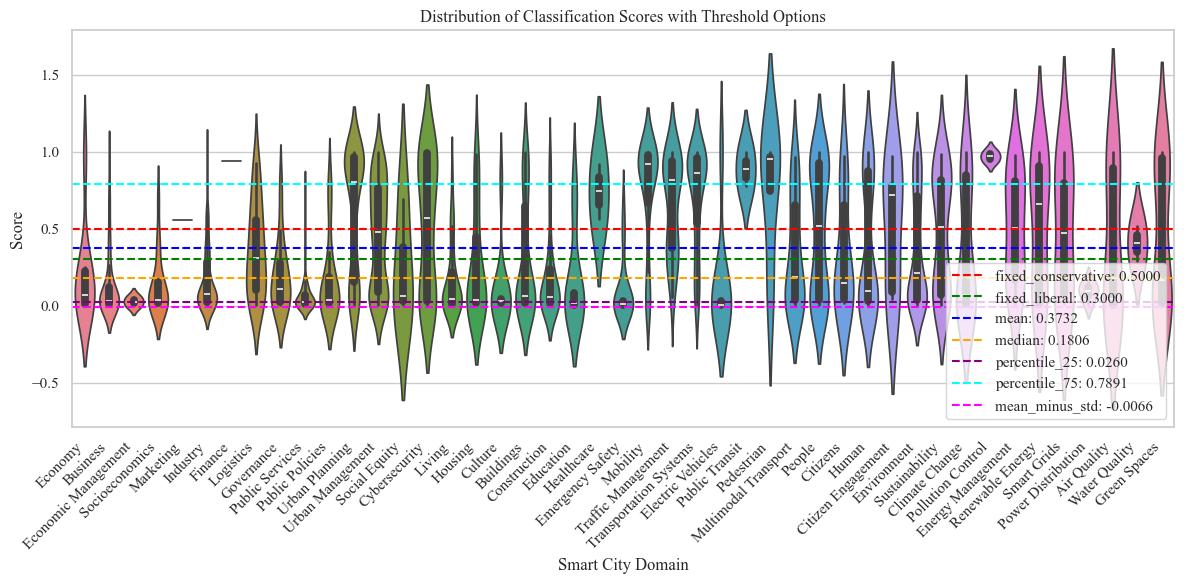

In [10]:
# Calculate statistical thresholds
all_scores = []
for scores in domain_scores.values():
    all_scores.extend([s for s in scores if not np.isnan(s)])

# Calculate various statistical thresholds
thresholds = {
    "fixed_conservative": 0.5,  # Standard fixed threshold
    "fixed_liberal": 0.3,  # More inclusive fixed threshold
    "mean": np.mean(all_scores),  # Average of all scores
    "median": np.median(all_scores),  # Median (50th percentile)
    "percentile_25": np.percentile(all_scores, 25),  # 25th percentile
    "percentile_75": np.percentile(all_scores, 75),  # 75th percentile
    "mean_minus_std": np.mean(all_scores) - np.std(all_scores),  # Lower statistical bound
}

# Display calculated thresholds
print("\n📏 Possible Thresholds:")
for name, value in thresholds.items():
    print(f"  - {name}: {value:.4f}")

# Let's see how many domains would be assigned with each threshold
print("\n📊 Domains Assigned per Abstract with Different Thresholds:")
for name, threshold in thresholds.items():
    domains_per_abstract = []
    
    # Iterate through the DataFrame rows
    for _, row in df_filtered.iterrows():
        if 'classification_scores' in row and not pd.isna(row['classification_scores']).any():
            # Count domains above threshold
            assigned_domains = sum(1 for score in row['classification_scores'] if score >= threshold)
            domains_per_abstract.append(assigned_domains)

    avg_domains = np.mean(domains_per_abstract) if domains_per_abstract else 0
    print(f"  - {name} (threshold={threshold:.4f}): {avg_domains:.2f} domains per abstract")

# Plot threshold lines on the violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(data=scores_df)  # Use the scores_df created in the previous cell
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Classification Scores with Threshold Options")
plt.ylabel("Score")
plt.xlabel("Smart City Domain")

# Add horizontal lines for thresholds with different colors
colors = ["red", "green", "blue", "orange", "purple", "cyan", "magenta"]
for (name, value), color in zip(thresholds.items(), colors):
    plt.axhline(y=value, color=color, linestyle="--", label=f"{name}: {value:.4f}")

plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Assign Macro Smart City Domains

In [14]:
from collections import Counter

def assign_macro_domains_to_df(df, domain_hierarchy, score_threshold=0.5):
    """
    Assigns each row in the DataFrame to one or more macro smart city domains
    based on classification scores that exceed a threshold.

    Args:
        df (DataFrame): DataFrame with classification results
        domain_hierarchy (dict): Smart city domains hierarchy dictionary
        score_threshold (float): Minimum score to assign a domain (default: 0.5)

    Returns:
        DataFrame: Same DataFrame with macro_domains column added
    """
    # Create a mapping from subdomain to parent domain
    subdomain_to_macro = {}
    for macro_domain, subdomains in domain_hierarchy.items():
        for subdomain in subdomains:
            subdomain_to_macro[subdomain.lower()] = macro_domain
    
    # Create list to store macro domains for each row
    all_macro_domains = []
    
    # Process each row in the DataFrame
    for _, row in df.iterrows():
        # Skip if classification data doesn't exist
        if 'classification_labels' not in row or pd.isna(row['classification_labels']).any():
            all_macro_domains.append([])
            continue
            
        # Get classification results
        labels = row['classification_labels']
        scores = row['classification_scores']
        
        # Initialize domain scores dictionary
        domain_scores = {macro: 0.0 for macro in domain_hierarchy.keys()}
        
        # Aggregate scores by macro domain
        for label, score in zip(labels, scores):
            label_lower = label.lower()
            # Find the macro domain for this label
            for subdomain, macro_domain in subdomain_to_macro.items():
                if subdomain.lower() in label_lower:
                    # Take the highest score for each macro domain
                    domain_scores[macro_domain] = max(
                        domain_scores[macro_domain], score
                    )
                    break
        
        # Filter domains by threshold and sort by score
        macro_domains = [
            {"domain": domain, "score": score}
            for domain, score in domain_scores.items()
            if score >= score_threshold
        ]
        
        # Sort by score in descending order
        macro_domains.sort(key=lambda x: x["score"], reverse=True)
        
        # Add to list
        all_macro_domains.append(macro_domains)
    
    # Add macro domains to DataFrame
    df_result = df.copy()
    df_result['macro_domains'] = all_macro_domains
    
    return df_result

# Apply the function to DataFrame
df_with_domains = assign_macro_domains_to_df(df_filtered, smart_city_domains, score_threshold=0.4)

# Get statistics on domain distribution
if not df_with_domains.empty:
    all_domains = []
    for domains in df_with_domains['macro_domains']:
        all_domains.extend([d["domain"] for d in domains])
    
    domain_counts = Counter(all_domains)
    
    print("\n📊 Domain Distribution:")
    for domain, count in domain_counts.most_common():
        print(f"  - {domain}: {count} abstracts")
    
    print(f"\nAverage domains per abstract: {len(all_domains)/len(df_with_domains):.2f}")
    
    # Count abstracts with multiple domains
    multi_domain_count = sum(
        1 for domains in df_with_domains['macro_domains'] if len(domains) > 1
    )
    print(
        f"Abstracts with multiple domains: {multi_domain_count} ({multi_domain_count/len(df_with_domains)*100:.2f}%)"
    )


📊 Domain Distribution:
  - Smart Governance: 142 abstracts
  - Smart Environment: 82 abstracts
  - Smart Mobility: 68 abstracts
  - Smart Living: 48 abstracts
  - Smart People: 38 abstracts
  - Smart Economy: 32 abstracts

Average domains per abstract: 1.34
Abstracts with multiple domains: 121 (39.41%)


# Visualize Domain Distribution
Create visualizations (e.g., bar charts, word clouds) to display the distribution of smart city domains in the dataset and highlight key terms associated with each domain.

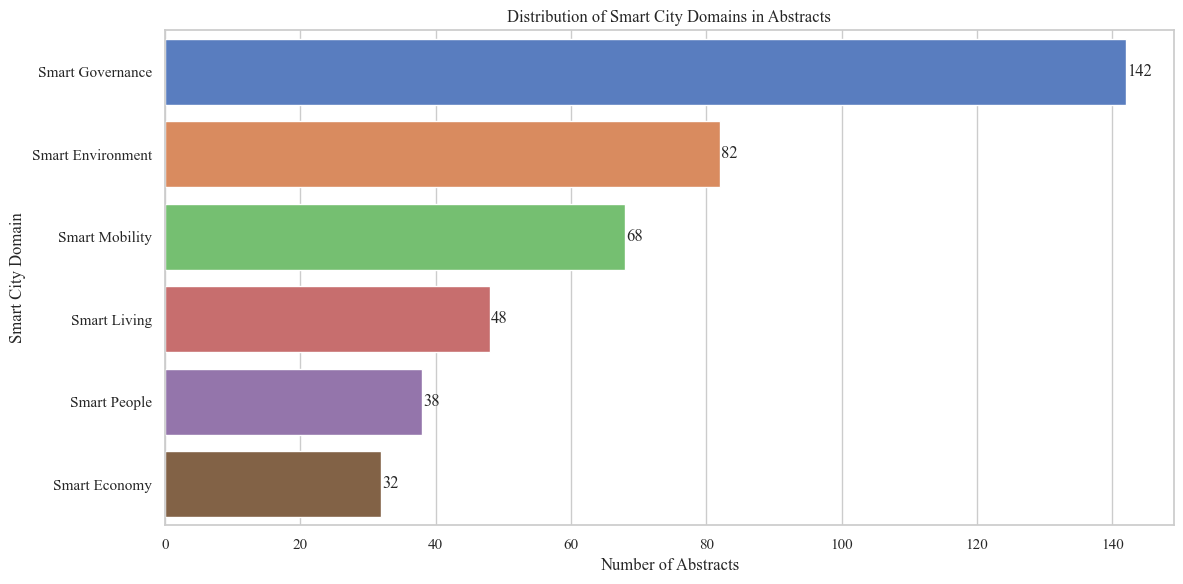

In [12]:
# Plot the distribution of domains using a matte color palette
palette = sns.color_palette("muted", n_colors=len(domain_counts))

# Create the domain and count lists
domains = [domain for domain, count in domain_counts.most_common()]
counts = [count for domain, count in domain_counts.most_common()]

# Create a bar plot of domain counts with the correct parameter structure
plt.figure(figsize=(12, 6))
sns.barplot(
    x=counts,
    y=domains,
    hue=domains,  # Add this parameter
    palette=palette,
    legend=False,  # Add this parameter
)
plt.xlabel("Number of Abstracts")
plt.ylabel("Smart City Domain")
plt.title("Distribution of Smart City Domains in Abstracts")

# Add value labels to the end of each bar
for i, count in enumerate(counts):
    plt.text(count + 0.2, i, str(count), va="center")

# Adjust layout and margins
plt.tight_layout()

# Save the plot
# plt.savefig("../data/03_domain_distribution.png")

# Display the plot
plt.show()

# Filter Articles with no Domain Assigned

In [15]:
no_domain_mask = df_with_domains['macro_domains'].apply(lambda x: len(x) == 0)
no_domain_df = df_with_domains[no_domain_mask]
    
# Remove non assigned macro domains from the DataFrame
df_with_domains = df_with_domains[~no_domain_mask].copy()
df_with_domains = df_with_domains.reset_index(drop=True)
print(f"\nFiltered DataFrame size: {len(df_with_domains)} articles with assigned domains")


Filtered DataFrame size: 238 articles with assigned domains


# Save the Results

In [16]:
# Save the DataFrame with macro domains to a JSON file
df_with_domains.to_json("../data/06_classified_macro_smart_city_domains.json", orient="records", indent=4)

# Save the datafram with no assigned domains to a JSON file
no_domain_df.to_json("../data/06_1_no_assigned_domains.json", orient="records", indent=4)